# ¿Cómo funcionan los filtros faciales?

In [1]:
import dlib
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import imutils

In [3]:
plt.rcParams['figure.figsize'] = [20, 10]

## Cargando la imagen

In [4]:
# img_path = 'imgs/messi_2.jpg'
img_path = 'imgs/messi_1.jpeg'

In [5]:
img: np.ndarray = dlib.load_rgb_image(img_path)

print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(475, 950, 3)


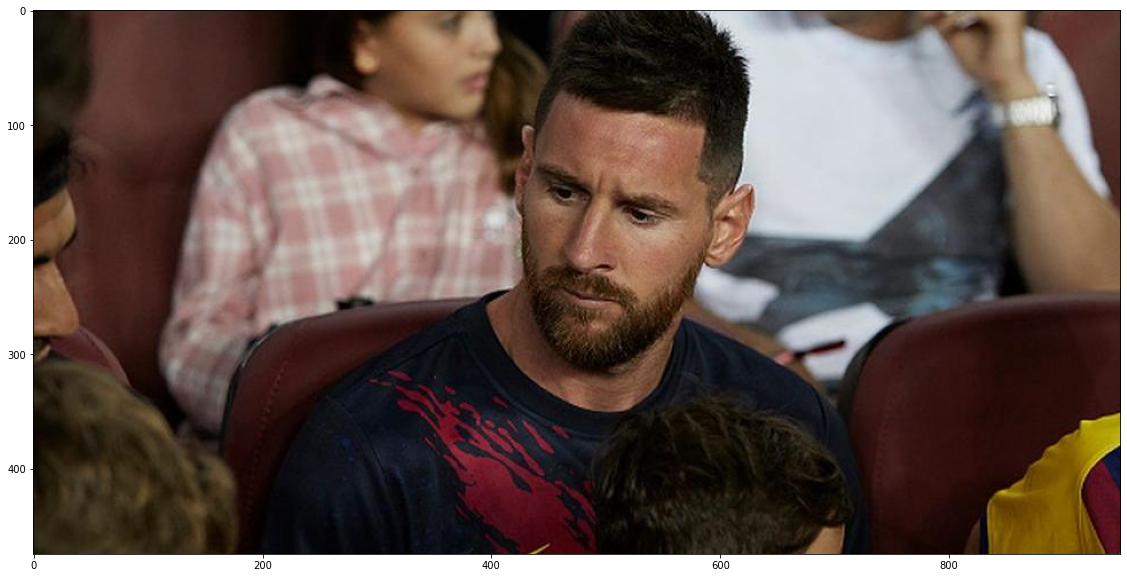

In [6]:
plt.imshow(img)
plt.show()

# HOG

1. Normalizar la intensidad
2. Calcular el mapa de bordes
3. Agrupar los pixeles en bloques de $8\times8$
4. Calcular los angulos de los gradientes, agrupar por $20$ grados ($9$ casillas) y elegir el mas repetido
5. Agrupar en bloques de $16\times16$
    * concatenar los vectores descriptores ($36$ casillas)
    * normalizar el vector extendido para reducir variacion de iluminacion
6. Se obtienen $\frac{n}{8}-1$ bloques de $16\times16$ de alto y ancho, con cada bloque su vector descriptor de $36$ elementos

![image](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/08/article-image-8.png)

![image2](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/08/index_9.png)

In [7]:
face_detector = dlib.get_frontal_face_detector()

In [8]:
detections = face_detector(img)

print(len(detections))

1


413 114 592 293


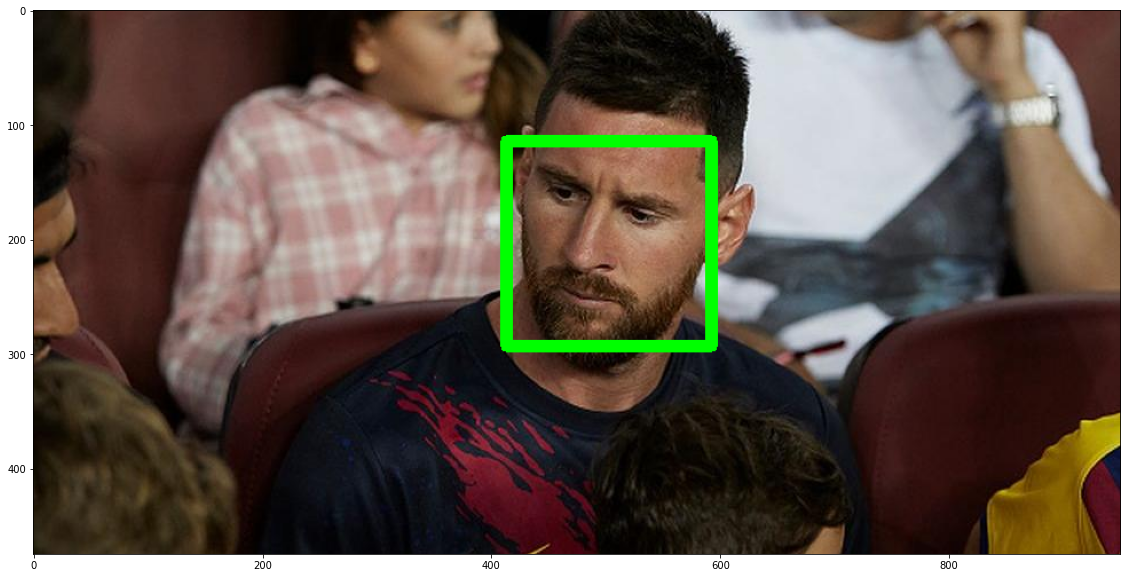

In [9]:
img_to_show = img.copy()

for detection in detections:
    x1, y1, x2, y2 = detection.left(), detection.top(), detection.right(), detection.bottom()
    print(x1, y1, x2, y2)
    
    cv2.rectangle(img_to_show, (x1, y1), (x2, y2), (0, 255, 0), 10)
    
plt.imshow(img_to_show)
plt.show()

## Landmark Prediction

https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf

In [10]:
predictor_path = 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)

413 114 592 293


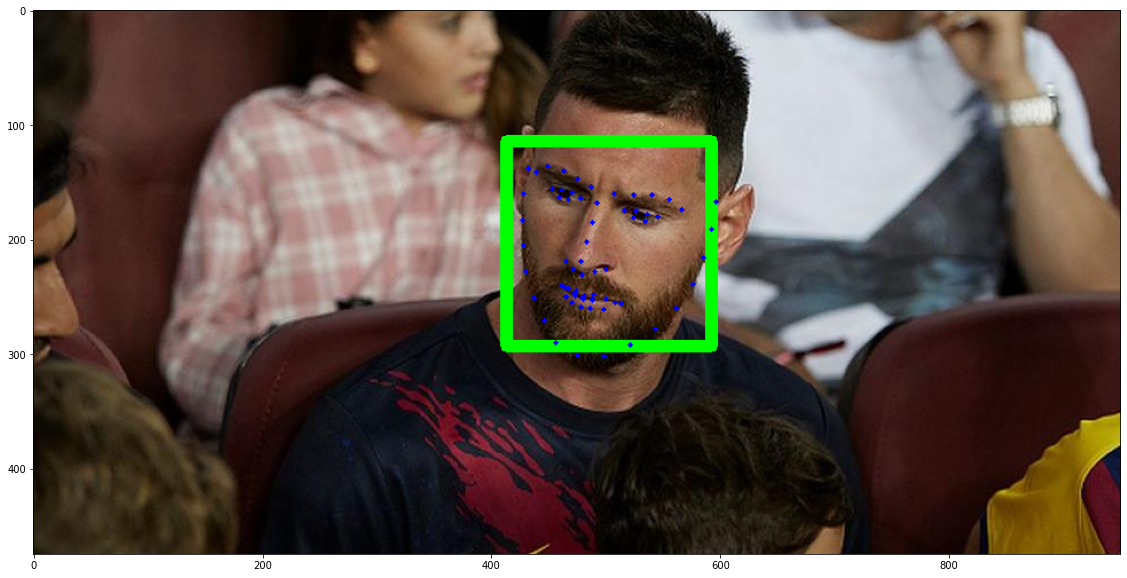

In [11]:
img_to_show = img.copy()

for detection in detections:
    x1, y1, x2, y2 = detection.left(), detection.top(), detection.right(), detection.bottom()
    print(x1, y1, x2, y2)
    
    cv2.rectangle(img_to_show, (x1, y1), (x2, y2), (0, 255, 0), 10)
    
    landmarks = predictor(img, detection)
    
    for e in list(map(lambda p: (p.x, p.y), landmarks.parts())):
        cv2.circle(img_to_show, (e[0], e[1]), 2, (0, 0, 255), -1)
    
plt.imshow(img_to_show)
plt.show()

In [12]:
landmarks_list = list(map(lambda p: (p.x, p.y), landmarks.parts()))
landmarks_list

[(432, 138),
 (428, 160),
 (427, 183),
 (428, 205),
 (430, 228),
 (437, 251),
 (446, 271),
 (456, 290),
 (475, 301),
 (498, 302),
 (521, 292),
 (543, 278),
 (561, 260),
 (576, 239),
 (585, 216),
 (592, 191),
 (596, 167),
 (439, 141),
 (449, 136),
 (463, 140),
 (475, 147),
 (487, 154),
 (507, 160),
 (524, 161),
 (540, 161),
 (555, 165),
 (566, 174),
 (492, 168),
 (488, 185),
 (483, 202),
 (478, 219),
 (465, 219),
 (471, 226),
 (479, 231),
 (490, 228),
 (500, 226),
 (453, 156),
 (461, 157),
 (470, 159),
 (478, 164),
 (467, 165),
 (459, 163),
 (516, 175),
 (526, 175),
 (536, 178),
 (545, 180),
 (534, 184),
 (524, 181),
 (461, 240),
 (467, 243),
 (474, 245),
 (481, 249),
 (489, 248),
 (500, 252),
 (513, 256),
 (498, 261),
 (486, 260),
 (478, 259),
 (470, 255),
 (465, 250),
 (464, 242),
 (473, 249),
 (480, 252),
 (488, 253),
 (508, 255),
 (488, 252),
 (479, 251),
 (472, 247)]

In [13]:
landmarks_dict = {}
landmarks_dict['left_eye'] = landmarks_list[36:42]
landmarks_dict['right_eye'] = landmarks_list[42:48]
landmarks_dict['mouth'] = landmarks_list[48:68]

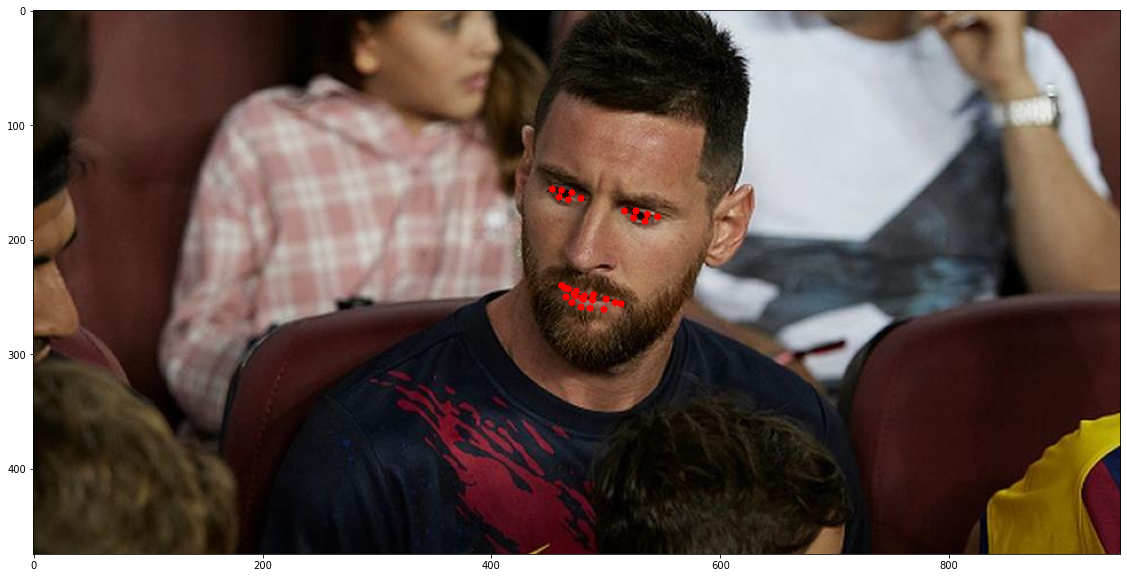

In [14]:
img_to_show = img.copy()
for part in landmarks_dict.values():
    for p in part:
        cv2.circle(img_to_show, p, 3, (255, 0, 0), -1)
    
plt.imshow(img_to_show)
plt.show()

# Mostacho

In [15]:
mostacho = cv2.imread('imgs/mostacho.png', cv2.IMREAD_UNCHANGED)
mostacho.shape

(1034, 2400, 4)

Se delimitan las coordenadas del mostacho

1. Horizontalmente respecto a la boca
2. Verticalmente respecto a la nariz y el labio superior

In [16]:
size_offset = 50

# Extremos horizontales de los labios
(xl, yt), (xr, yb) = landmarks_list[48], landmarks_list[54]
xl -= size_offset
xr += size_offset
print(xl, yt, xr, yb)

411 240 563 256


In [17]:
# Labio 51 y Nariz 33
y_position = (landmarks_list[51][1] + landmarks_list[33][1])//2 # centro entre nariz y labio
x_position = landmarks_list[51][0]

Se ajusta el mostacho al tamaño de los labios mas el extra

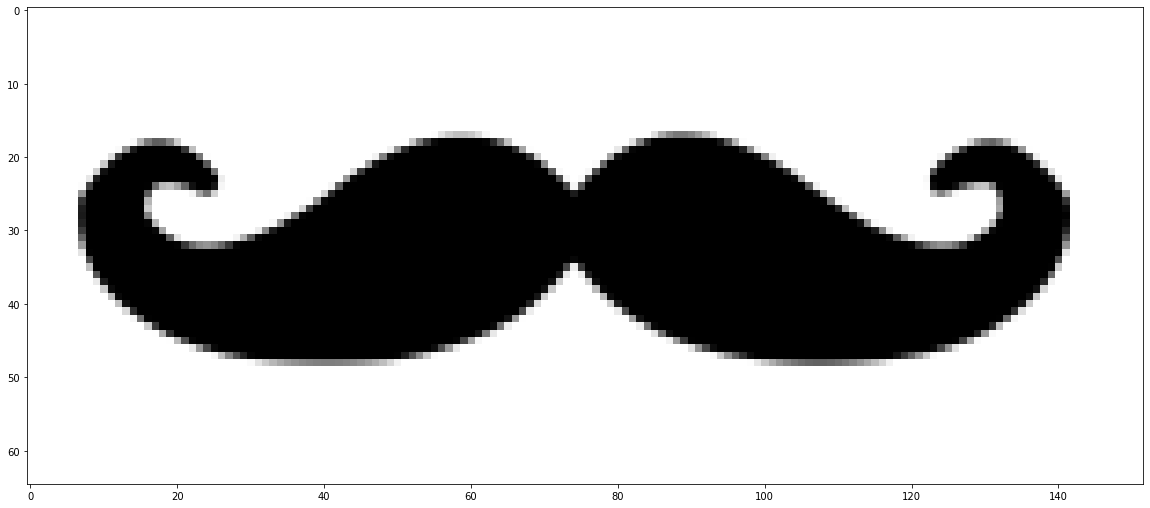

(65, 152, 4)


In [18]:
small_mostacho = imutils.resize(mostacho, width=xr - xl)

plt.imshow(small_mostacho)
plt.show()

print(small_mostacho.shape)

Calculando el ángulo para ajustarse a la boca

In [19]:
import math

angle = math.degrees(math.atan((yb-yt)/(xr-xl)))
print(angle)

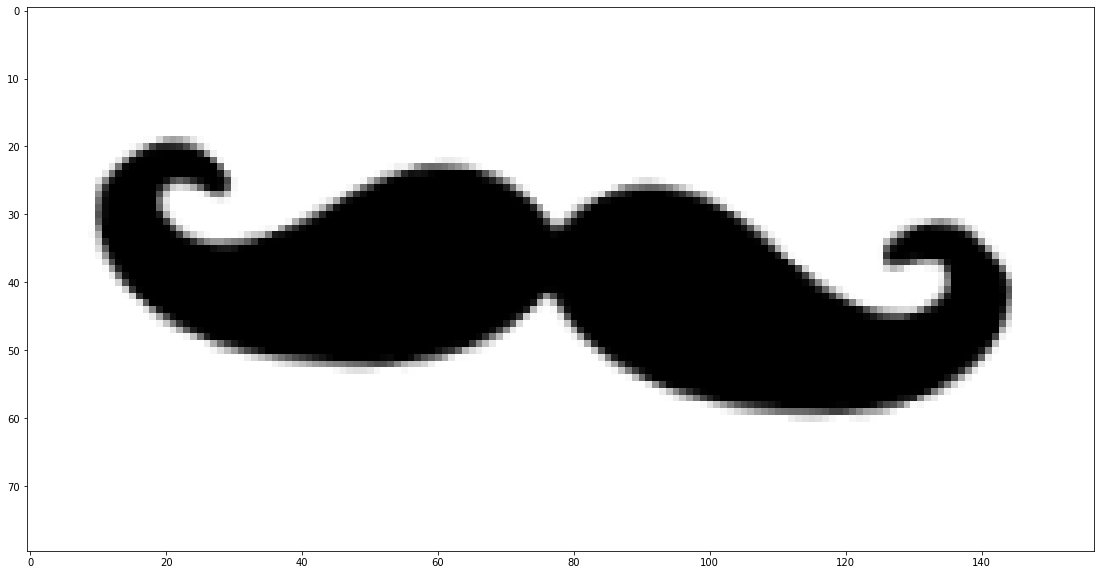

In [21]:
small_mostacho = imutils.rotate_bound(small_mostacho, angle)

plt.imshow(small_mostacho)
plt.show()

# Combinando ambas imágenes

* Se ajusta el valor de la transparencia entre $[0, 1]$
* Se crea una matriz de transparencias del filtro y su complemento sobre la imagen
* Se calcula la suma ponderada

(80, 157, 4)


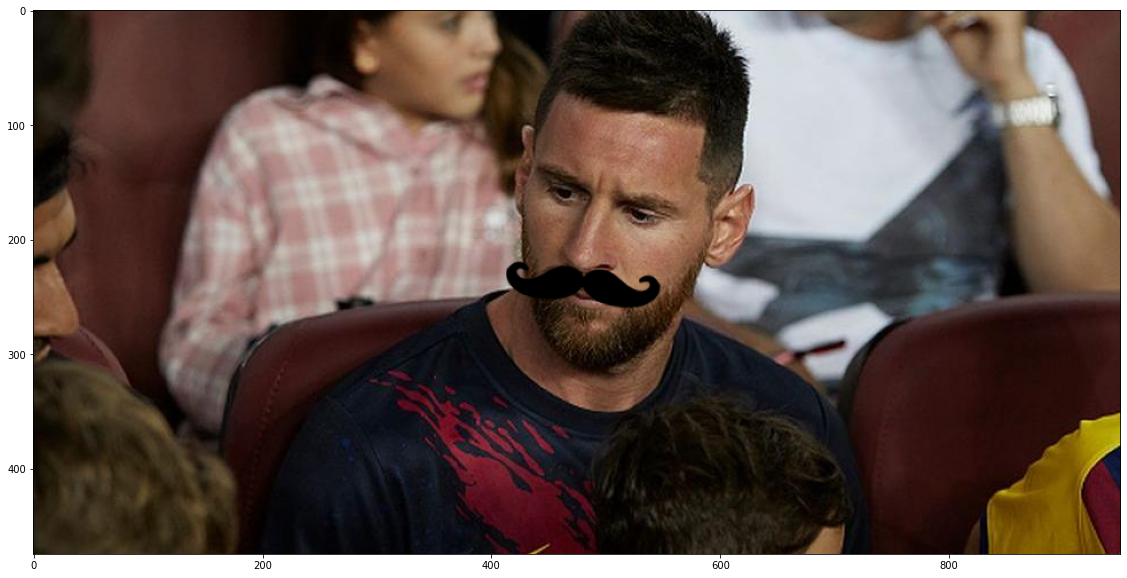

In [22]:
final_img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)

# Se ajusta el valor de la transparencia entre
alpha_filtro = np.expand_dims(small_mostacho[:, :, 3] / 255.0, axis=2) # alto x ancho x 1
# Se crea una matriz de transparencias del filtro y su complemento sobre la imagen
alpha_img = 1.0 - alpha_filtro

x1 = x_position - small_mostacho.shape[1]//2
x2 = x1 + small_mostacho.shape[1]
y1 = y_position - small_mostacho.shape[0]//2
y2 = y1 + small_mostacho.shape[0]

# Se calcula la suma ponderada
print((alpha_filtro * small_mostacho[:, :] + alpha_img * final_img[y1:y2, x1:x2]).shape)
final_img[y1:y2, x1:x2] = (alpha_filtro * small_mostacho[:, :] + alpha_img * final_img[y1:y2, x1:x2])
res = final_img[:, :, :3]

plt.imshow(res)
plt.show()